In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [55]:
# 독립변인 만들기
factors_plus = np.arange(1,2,0.2)   # 양의 상관관계 : 높이가 클수록 원하는 결과 도출
factors_minus = np.arange(1,2,0.2)  # 음의 상관관계 : 높이가 낮을수록 원하는 결과 도출

factors = []
iteration = 500     # 파라미터 조정 횟수
for _ in range(iteration):
    factors_plus += 0.001   # 회당 파라미터 조정
    factors_minus -= 0.001  # 회당 파라미터 조정

    factor_concat = np.hstack([factors_plus, factors_minus])    # 모든 파라미터 병합
    factors.append(factor_concat)

factors = np.array(factors)
print(factors.shape)

(500, 10)


In [56]:
# 종속변인 만들기
x_start = -2.5
x_end = 2.1

freq = [x for x in np.arange(x_start, x_end, 0.1)]
f = [(2*(x ** 4)) + (x ** 3) + (-8 * (x ** 2)) + 12 for x in np.arange(x_start, x_end, 0.1)]
result_scaled = minmax_scale(f)

observations = []
for alpha in np.arange(0.5, 1, 0.1):
    for _ in range(100):
        error = np.random.rand(len(f)) * alpha
        observation = result_scaled + error
        observations.append(observation)

observations = np.array(observations)
print(observations.shape)


(500, 46)


In [57]:
# 독립변인과 종속변인 병합 (for shuffling)
dataset = np.hstack([factors, observations])
print(dataset.shape)

(500, 56)


In [58]:
# 셔플링 (for 정상적인 학습)
dataset_shuffled = dataset.copy()
np.random.shuffle(dataset_shuffled)

inputs = dataset_shuffled[:, :10]
labels = dataset_shuffled[:, 10:]
print(inputs.shape)
print(labels.shape)


(500, 10)
(500, 46)


In [59]:
# # 임계값 만들기
# def threshold():
#     ty1 = np.arange(0.6, 1.5, 0.1)
#     tx1 = np.array([-2] * len(ty1))
#     tx2 = np.arange(-2, -1, 0.1)
#     ty2 = np.array([0.6] * len(tx2))
#     ty3 = ty1.copy()
#     tx3 = np.array([-1] * len(ty3))

#     ty4 = np.arange(0.8, 1.5, 0.1)
#     tx4 = np.array([1] * len(ty4))
#     tx5 = np.arange(1, 1.5, 0.1)
#     ty5 = np.array([0.8] * len(tx5))
#     ty6 = ty4.copy()
#     tx6 = np.array([1.5] * len(ty6))

#     tx = [np.hstack([tx1, tx2, tx3]), np.hstack([tx4, tx5, tx6])]
#     ty = [np.hstack([ty1, ty2, ty3]), np.hstack([ty4, ty5, ty6])]
#     return tx, ty

46


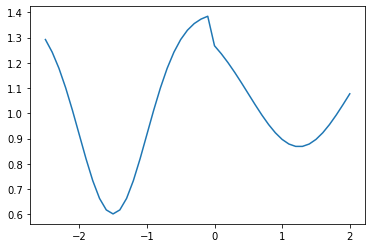

In [60]:
# 임계값 만들기
import scipy

def normal_distribution(x_start, x_end, mu, std, intercept):
  # xx = np.linspace(-5, 5, 100
  X = np.arange(x_start, x_end, 0.1)
  rv = scipy.stats.norm(mu, std)
  pdf = (rv.pdf(X)*-1) + intercept 
  return X, pdf

X1, pdf1 = normal_distribution(-2.5, 0, -1.5, 0.5, 1.4)
X2, pdf2 = normal_distribution(0, 2.1, 1.25, 0.75, 1.4)
RV = np.hstack([X1,X2]) # random variable
pdf = np.hstack([pdf1,pdf2])  # normal distribution
threshold = [RV, pdf]
plt.plot(RV, pdf)
print(len(RV))

In [76]:
# https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
# 모델 정의
import torch
from torch import nn

# Numpy의 ndarray를 파이토치의 텐서로 변환
X = torch.tensor(inputs, dtype=torch.float32)
Y = torch.tensor(labels, dtype=torch.float32)

# N은 배치 크기; D_in은 입력의 차원; D_out은 출력 차원
N, D_in, D_out = 64, len(inputs[0]), len(labels[0])

# 모델 정의
model = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.ReLU(),
    nn.Linear(100, 32),
    nn.ReLU(),
    nn.Linear(32, D_out)
)

# 손실함수 정의
loss_fn = torch.nn.MSELoss(reduction='sum')
def my_loss(target, output):
    loss = torch.mean((output - target)**2)
    return loss

def my_loss2(target, output, threshold):
    loss = torch.mean(((output - target)**2) + ((output - threshold)**2))
    return loss

# optim 패키지를 사용하여 모델의 가중치를 갱신할 Optimizer를 정의합니다.
# 여기서는 Adam을 사용하겠습니다; optim 패키지는 다른 다양한 최적화 알고리즘을
# 포함하고 있습니다. Adam 생성자의 첫번째 인자는 어떤 Tensor가 갱신되어야 하는지
# 알려줍니다.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [62]:
# # 모델 학습
# num_epochs = 200

# losses = []
# for epoch in range(num_epochs):
#     # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
#     y_pred = model(X)

#     # 손실을 계산하고 출력합니다.
#     # loss = loss_fn(y_pred, Y)
#     loss = my_loss(y_pred, Y)
#     if epoch % 10 == 0:
#         print(epoch, loss.item())

#     losses.append(loss.item())
#     # 역전파 단계 전에, Optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인)
#     # 갱신할 변수들에 대한 모든 변화도를 0으로 만듭니다. 이렇게 하는 이유는
#     # 기본적으로 .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고)
#     # 누적되기 때문입니다. 더 자세한 내용은 torch.autograd.backward에 대한 문서를
#     # 참조하세요.
#     optimizer.zero_grad()

#     # 역전파 단계: 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
#     loss.backward()

#     # Optimizer의 step 함수를 호출하면 매개변수가 갱신됩니다.
#     optimizer.step()


In [63]:
# # loss 그래프
# plt.plot(losses)

In [77]:
# 모델 학습
num_epochs = [200,1000]
loss_list = []
models = []
for i in range(2): # 서로 다른 custom loss 적용
  losses = []
  for epoch in range(num_epochs[i]):
      # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
      y_pred = model(X)

      # 손실을 계산하고 출력합니다.
      # loss = loss_fn(y_pred, Y)
      if i == 0:
        loss = my_loss(y_pred, Y)
      else:
        loss = my_loss2(y_pred, Y, pdf)
      if epoch % 100 == 0:
          print(epoch, loss.item())

      losses.append(loss.item())
      # 역전파 단계 전에, Optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인)
      # 갱신할 변수들에 대한 모든 변화도를 0으로 만듭니다. 이렇게 하는 이유는
      # 기본적으로 .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고)
      # 누적되기 때문입니다. 더 자세한 내용은 torch.autograd.backward에 대한 문서를
      # 참조하세요.
      optimizer.zero_grad()

      # 역전파 단계: 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
      loss.backward()

      # Optimizer의 step 함수를 호출하면 매개변수가 갱신됩니다.
      optimizer.step()
  loss_list.append(losses)
  models.append(model)


0 0.5110798478126526
100 0.04432787373661995
0 0.21431204389965036
100 0.21421274608735502
200 0.21418433816439184
300 0.21416386154028375
400 0.21414363766755254
500 0.2141225298017797
600 0.21410065275414808
700 0.2140781767769864
800 0.21405590146893796
900 0.21403429847807542


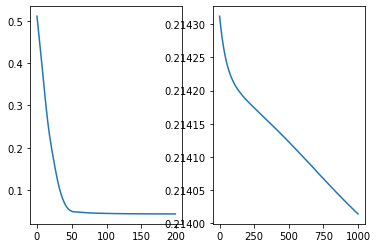

In [78]:
# loss 그래프
fig, axes = plt.subplots(1,2)
axes[0].plot(loss_list[0])
axes[1].plot(loss_list[1])

In [ ]:
# # 예측 (직사각형 threshold)
# tx, ty = threshold[0], threshold[1]
# for i, x, y in zip(range(2), tx, ty):
#     if i == 0:
#         plt.plot(x, y, color = 'black', label='threshold')
#     else:
#         plt.plot(x, y, color='black')

# model.eval()
# pred = model(X[0]).detach().numpy()
# plt.plot(freq, labels[0], label='observation')
# plt.plot(freq, pred, label='prediction')
# plt.legend()

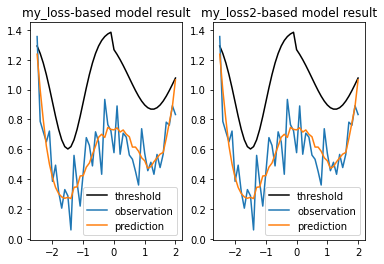

In [90]:
# 예측 (정규분포 기반 threshold)
sample = 3
tx, ty = threshold
fig, axes = plt.subplots(1,2)
for i, model in enumerate(models):
  axes[i].plot(tx, ty, color = 'black', label='threshold')
  model.eval()
  pred = model(X[sample]).detach().numpy()
  axes[i].plot(freq, labels[sample], label='observation')
  axes[i].plot(freq, pred, label='prediction')
  axes[i].legend()
  if i==0:
    axes[i].set_title('my_loss-based model result') # MSE
  else:
    axes[i].set_title('my_loss2-based model result') # mean(((output - target)**2) + ((output - threshold)**2))